# Image Captioning 

In [1]:
# Setup dasar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from tqdm.notebook import trange, tqdm
import random

# Setup torch
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.distributions import Categorical

# Setup torchvision
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Setup tokenisasi
from transformers import AutoTokenizer
os.environ["TOKENIZERS_PARALLELISM"] = "false"

torch.backends.cuda.matmul.allow_tf32 = True

# Mengecek ketersediaan GPU
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(f"Using device : {device}")

Using device : cuda


In [2]:
# Inisialisasi kecepatan belajar
learning_rate = 1e-4

# Inisialisasi ukuran gambar
image_size = 255

# Inisialisasi perulangan saat training
nepochs = 25

# Inisialisasi batch
batch_size = 32

# Inisialisasi lokasi berkas
checkpoint_path = 'D:/Project/Image Captioning'
data_set_root='D:/Project/Image Captioning/coco_captions'
train_set ='train2014'
validation_set ='val2014'

train_image_path = os.path.join(data_set_root, train_set)
train_ann_file = '{}/annotations/captions_{}.json'.format(data_set_root, train_set)

val_image_path = os.path.join(data_set_root, validation_set)
val_ann_file = '{}/annotations/captions_{}.json'.format(data_set_root, validation_set)

# Data Processing and Tokenization

In [3]:
# Class untuk mengakses 1 dari 5 caption yang tersedia
class SampleCaption(nn.Module):
    def __call__(self, sample):
        rand_index = random.randint(0, len(sample) - 1)
        return sample[rand_index]

In [4]:
# Transformasi Gambar agar gambar konsisten
train_transform = transforms.Compose([transforms.Resize(image_size),
                                      transforms.RandomCrop(image_size),
                                      transforms.AutoAugment(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])]) 

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])]) 

# Transformasi caption
train_dataset = datasets.CocoCaptions(root=train_image_path,
                                      annFile=train_ann_file,
                                      transform=train_transform,
                                      target_transform=SampleCaption())

eval_dataset = datasets.CocoCaptions(root=val_image_path,
                                     annFile=val_ann_file,
                                     transform=transform,
                                     target_transform=SampleCaption())


data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
data_loader_eval = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

loading annotations into memory...
Done (t=0.77s)
creating index...
index created!
loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


In [5]:
# Membuat objek dataloader yang dapat diubah
dataiter = next(iter(data_loader_eval))
# Sampel dari objek yang dapat diubah
test_images, test_captions = dataiter
test_images = test_images.to(device)

a white dog is sleeping on a street and a bicycle


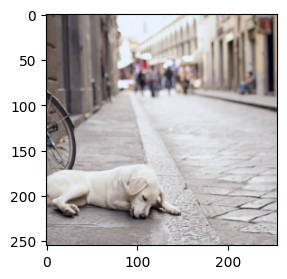

In [6]:
index = 2
# Memvisualisasikan seluruh kumpulan gambar!
plt.figure(figsize = (3,3))
out = torchvision.utils.make_grid(test_images[index].cpu(), 1, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

caption = test_captions[index]
print(caption)

In [7]:
# Memuat tokenizer pra-latih dari HuggingFace untuk model DistilBERT.
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [8]:
# Memeriksa ukuran kosa kata (vocabulary size) dari tokenizer
tokenizer.vocab_size

30522

In [9]:

tokens = tokenizer(test_captions, padding=True, truncation=True, return_tensors="pt")

In [10]:
token_ids = tokens['input_ids'][index]
tokens['input_ids']

tensor([[  101,  1037, 10818, 14513,  2007,  2070,  6007,  1998,  1037,  3899,
          5777,  2006,  2068,   102,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  2019,  2214,  9055,  9083,  3875,  2060, 18580,  2007,  1037,
          2829,  5898,  2835,  1012,   102,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  1037,  2317,  3899,  2003,  5777,  2006,  1037,  2395,  1998,
          1037, 10165,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  1037,  2793,  7719,  2006,  2327,  1997,  1037, 16641,  1998,
          1037,  4624,  1012,   102,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  1996, 21025, 27528,  7959,  2003,  2108,  2921,  2011,  2993,
         24274,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  1037,  2282,  2007,  8397,  1010,  1037,  2795,  1010,  1998,
          1

In [11]:
print(tokenizer.decode(token_ids))

[CLS] a white dog is sleeping on a street and a bicycle [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [12]:
class TokenDrop(nn.Module):
    """For a batch of tokens indices, randomly replace a non-specical token.
    
    Args:
        prob (float): probability of dropping a token
        blank_token (int): index for the blank token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, blank_token=1, eos_token=102):
        self.prob = prob
        self.eos_token = eos_token
        self.blank_token = blank_token

    def __call__(self, sample):
        # Ambil sampel distribusi bernoulli secara acak dengan p=prob
        # untuk membuat mask dimana 1 berarti kita akan mengganti token tersebut
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        # hanya ganti jika tokennya bukan token eos
        can_drop = (~(sample == self.eos_token)).long()
        mask = mask * can_drop
        
        # Jangan mengganti token sos
        mask[:, 0] = torch.zeros_like(mask[:, 0]).long()
        
        replace_with = (self.blank_token * torch.ones_like(sample)).long()
        
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

# Membuat jaringan Encoder-Decoder

In [13]:
# Membagi gambar menjadi bagian kecil 
def extract_patches(image_tensor, patch_size=16):
    # Dapatkan dimensi tensor gambar
    bs, c, h, w = image_tensor.size()
    
    # Tentukan lapisan Unfold dengan parameter yang sesuai
    unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)
    
    # Terapkan Unfold ke tensor gambar
    unfolded = unfold(image_tensor)
    
    # Bentuk ulang tensor yang tidak dilipat agar sesuai dengan bentuk keluaran yang diinginkan
    # Bentuk keluaran: BSxLxH, dengan L adalah jumlah patch di setiap dimensi
    unfolded = unfolded.transpose(1, 2).reshape(bs, -1, c * patch_size * patch_size)
    
    return unfolded

# Penyematan posisi sinusoidal
# Membuat “peta” posisi dengan menggunakan gelombang sinus dan kosinus
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb
    
    
# Inisisalisasi modul decoder untuk arsitektur Transformer
class Decoder(nn.Module):
    def __init__(self, num_emb, hidden_size=128, num_layers=3, num_heads=4):
        super(Decoder, self).__init__()
        
        # Buat lapisan penyematan untuk token
        self.embedding = nn.Embedding(num_emb, hidden_size)
        # Inisialisasi bobot penyematan
        self.embedding.weight.data = 0.001 * self.embedding.weight.data

        # Inisialisasi penyematan posisi sinusoidal
        self.pos_emb = SinusoidalPosEmb(hidden_size)
        
        # Buat beberapa lapisan dekoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_size, nhead=num_heads, 
                                                   dim_feedforward=hidden_size * 4, dropout=0.0,
                                                   batch_first=True)
        # TransformerDecoder akan mengkloning decoder_layer "num_layers" kali
        self.decoder_layers = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
                
        # Tentukan lapisan linier untuk prediksi keluaran
        self.fc_out = nn.Linear(hidden_size, num_emb)
        
    def forward(self, input_seq, encoder_output, input_padding_mask=None, 
                encoder_padding_mask=None):        
        # Sematkan urutan masukan
        input_embs = self.embedding(input_seq)
        bs, l, h = input_embs.shape

        # Tambahkan penyematan posisi ke penyematan masukan
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, h).expand(bs, l, h)
        embs = input_embs + pos_emb
        causal_mask = torch.triu(torch.ones(l, l, device=input_seq.device), 1).bool()
        
        # Lewatkan embeddings melalui setiap blok transformator
        output = self.decoder_layers(tgt=embs, memory=encoder_output, tgt_mask=causal_mask,
                                     tgt_key_padding_mask=input_padding_mask, 
                                     memory_key_padding_mask=encoder_padding_mask)
        
        return self.fc_out(output)

    
# Inisialisasi modul Vision Encoder untuk arsitektur Transformer
class VisionEncoder(nn.Module):
    def __init__(self, image_size, channels_in, patch_size=16, hidden_size=128, num_layers=3, num_heads=4):
        super(VisionEncoder, self).__init__()
        
        self.patch_size = patch_size
        self.fc_in = nn.Linear(channels_in * patch_size * patch_size, hidden_size)
        
        seq_length = (image_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, hidden_size).normal_(std=0.02))
        
        # Buat beberapa blok transformator sebagai lapisan
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, 
                                                   dim_feedforward=hidden_size * 4, dropout=0.0, 
                                                   batch_first=True)
        # TransformerEncoder akan mengkloning encoder_layer "num_layers" kali
        self.encoder_layers = nn.TransformerEncoder(encoder_layer, num_layers) 
                
    def forward(self, image):  
        bs = image.shape[0]

        patch_seq = extract_patches(image, patch_size=self.patch_size)
        patch_emb = self.fc_in(patch_seq)

        # Tambahkan penyematan unik ke setiap penyematan token
        embs = patch_emb + self.pos_embedding
        
        # Lewatkan embeddings melalui setiap blok transformator
        output = self.encoder_layers(embs)
        
        return output
    
    
# Tentukan modul Vision Encoder-Decoder untuk arsitektur Transformer
class VisionEncoderDecoder(nn.Module):
    def __init__(self, image_size, channels_in, num_emb, patch_size=16, 
                 hidden_size=128, num_layers=(3, 3), num_heads=4):
        super(VisionEncoderDecoder, self).__init__()
        
        # Buat encoder dan decoder dengan parameter yang ditentukan
        self.encoder = VisionEncoder(image_size=image_size, channels_in=channels_in, patch_size=patch_size,
                               hidden_size=hidden_size, num_layers=num_layers[0], num_heads=num_heads)
        
        self.decoder = Decoder(num_emb=num_emb, hidden_size=hidden_size, 
                               num_layers=num_layers[1], num_heads=num_heads)

    def forward(self, input_image, target_seq, padding_mask):
        # Hasilkan masker padding untuk urutan target
        bool_padding_mask = padding_mask == 0

        # Enkode urutan masukan
        encoded_seq = self.encoder(image=input_image)
        
        # Decode urutan target menggunakan urutan yang dikodekan
        decoded_seq = self.decoder(input_seq=target_seq, 
                                   encoder_output=encoded_seq, 
                                   input_padding_mask=bool_padding_mask)
        return decoded_seq

# Inisialisasi Model dan Pengoptimal

In [14]:
# Mengatur Ukuran Embedding dan Konfigurasi Transformer
# Ukuran Embedding
hidden_size = 192

# Jumlah blok untuk Transformer (Encoder, Decoder)
num_layers = (6, 6)

# Kepala Perhatian Multihead
num_heads = 8

# Ukuran patches
patch_size = 8

# Membuat model
caption_model = VisionEncoderDecoder(image_size=image_size, channels_in=test_images.shape[1], 
                                     num_emb=tokenizer.vocab_size, patch_size=patch_size, 
                                     num_layers=num_layers,hidden_size=hidden_size, 
                                     num_heads=num_heads).to(device)

# Inisialisasi pengoptimal dengan parameter di atas
optimizer = optim.Adam(caption_model.parameters(), lr=learning_rate)

scaler = torch.amp.GradScaler("cuda")

# Inisialisasi loss function
loss_fn = nn.CrossEntropyLoss(reduction="none")

td = TokenDrop(0.5)

# Inisialisasi logger kerugian pelatihan
training_loss_logger = []
eval_loss_logger = []
start_epoch = 0

In [15]:
# Melihat banyaknya parameter dalam model
num_model_params = 0
for param in caption_model.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 18202554 (Approximately 18 Million) Parameters!


# Training

In [16]:
# Load Checkpoint
if os.path.exists(checkpoint_path):
    print("chackpoint exist, load model....")
    cp = torch.load("captioning_model.pt")
    caption_model.load_state_dict(cp["model_state_dict"])
    optimizer.load_state_dict(cp["optimizer_state_dict"])
    training_loss_logger = cp["train_data_logger"]
    eval_loss_logger = cp["eval_data_logger"]
    start_epoch = cp["epoch"]
else:
    print("chackpoint not exist")

chackpoint exist, load model....


C:\Users\USER\AppData\Local\Temp\ipykernel_13496\261607728.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cp = torch.load("captioning_model.pt")


In [17]:
# Ulangi selama beberapa waktu
for epoch in trange(start_epoch, nepochs, leave=False, desc="Epoch"):
    # Set the model in training mode
    caption_model.train()
    
    # Ulangi pemuat data pelatihan
    for images, captions in tqdm(data_loader_train, desc="Training", leave=False):
        
        images = images.to(device)
        
        # Tokenisasi dan pra-proses teksnya
        tokens = tokenizer(captions, padding=True, truncation=True, return_tensors="pt")
        token_ids = tokens['input_ids'].to(device)
        padding_mask = tokens['attention_mask'].to(device)
        bs = token_ids.shape[0]
        
        # Geser urutan masukan untuk membuat urutan target
        target_ids = torch.cat((token_ids[:, 1:], 
                                torch.zeros(bs, 1, device=device).long()), 1)
        
        tokens_in = td(token_ids)
        with torch.amp.autocast("cuda"):
            # Forward pass
            pred = caption_model(images, tokens_in, padding_mask=padding_mask)

        # Hitung kerugiannya
        loss_mask = (~(target_ids == 0)).float()
        loss = (loss_fn(pred.transpose(1, 2), target_ids) * loss_mask).sum()/loss_mask.sum()

        # Propagasi mundur
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Catat kerugian pelatihan
        training_loss_logger.append(loss.item())

    # Atur model dalam mode eval
    caption_model.eval()
    with torch.no_grad():
        # Ulangi pemuat data pelatihan
        for images, captions in tqdm(data_loader_eval, desc="Eval", leave=False):

            images = images.to(device)

            # Tokenisasi dan pra-proses teksnya
            tokens = tokenizer(captions, padding=True, truncation=True, return_tensors="pt")
            token_ids = tokens['input_ids'].to(device)
            padding_mask = tokens['attention_mask'].to(device)
            bs = token_ids.shape[0]

            # Geser urutan masukan untuk membuat urutan target
            target_ids = torch.cat((token_ids[:, 1:], 
                                    torch.zeros(bs, 1, device=device).long()), 1)

            with torch.amp.autocast("cuda"):
                # Umpan ke depan
                pred = caption_model(images, token_ids, padding_mask=padding_mask)

            # Hitung kerugiannya
            loss_mask = (~(target_ids == 0)).float()
            loss = (loss_fn(pred.transpose(1, 2), target_ids) * loss_mask).sum()/loss_mask.sum()

            # Catat kerugian pelatihan
            eval_loss_logger.append(loss.item())
            
    # Simpan model dengan cepat setiap zaman
    torch.save({'epoch': epoch + 1,
                'train_data_logger': training_loss_logger,
                'eval_data_logger': eval_loss_logger,
                'model_state_dict': caption_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                 }, "captioning_model.pt")

print(f"Starting training from epoch {start_epoch} to {nepochs}")

Epoch: 0it [00:00, ?it/s]

Starting training from epoch 25 to 25


# Plot Loss

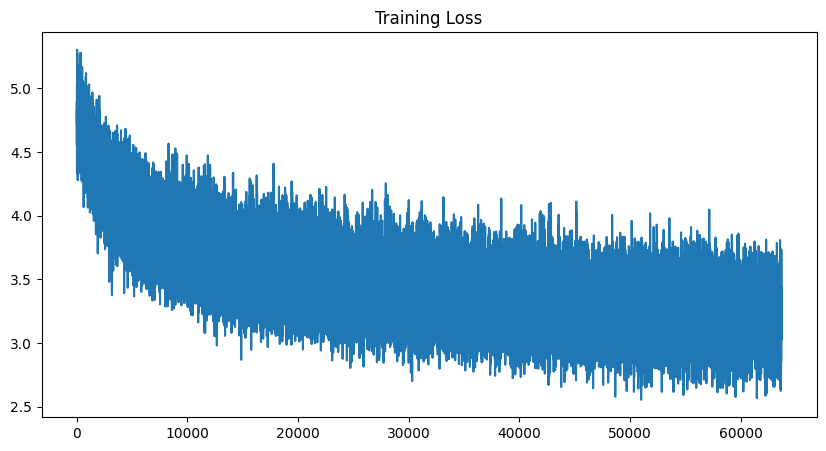

In [18]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(training_loss_logger[1000:])
_ = plt.title("Training Loss")

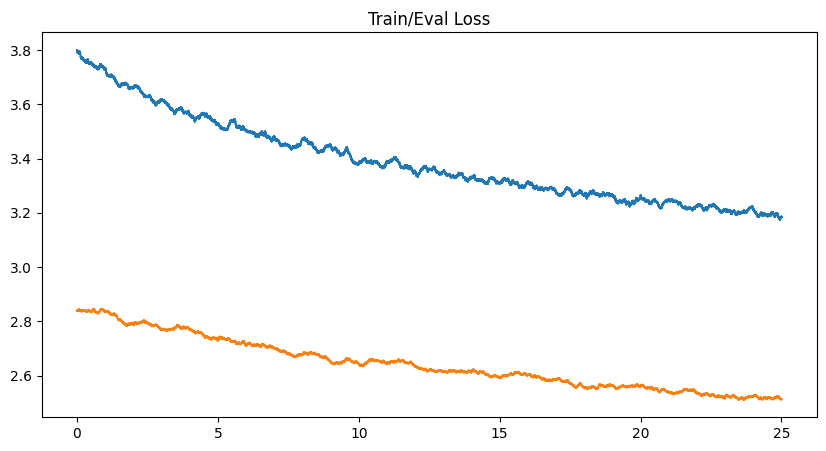

In [19]:
window_size = 512
_ = plt.figure(figsize=(10, 5))

train_data = np.convolve(np.array(training_loss_logger), np.ones(window_size)/window_size, mode="valid")[10000:]
eval_data = np.convolve(np.array(eval_loss_logger), np.ones(window_size)/window_size, mode="valid")[10000:]

_ = plt.plot(np.linspace(0, nepochs, len(train_data)), train_data)
_ = plt.plot(np.linspace(0, nepochs, len(eval_data)), eval_data)

_ = plt.title("Train/Eval Loss")

In [20]:
import nltk
import torch
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score

# Fungsi untuk melakukan decoding/generasi caption secara greedy
def generate_caption(model, image, tokenizer, max_length=30):
    model.eval()
    with torch.no_grad():
        # Mulai dengan token awal (CLS token, misalnya token 101 untuk distilbert-base-uncased)
        input_ids = torch.tensor([[tokenizer.cls_token_id]], device=image.device)
        padding_mask = torch.ones_like(input_ids, device=image.device)
        
        for _ in range(max_length):
            # Lakukan forward pass
            pred = model(image, input_ids, padding_mask=padding_mask)
            # Ambil token dengan probabilitas tertinggi pada posisi terakhir
            next_token_logits = pred[:, -1, :]  # bentuk: (batch, vocab_size)
            next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)
            input_ids = torch.cat([input_ids, next_token], dim=1)
            padding_mask = torch.cat([padding_mask, torch.ones_like(next_token, device=image.device)], dim=1)
            # Jika token akhir (SEP) telah dihasilkan, hentikan generasi
            if next_token.item() == tokenizer.sep_token_id:
                break

        # Decode token menjadi string, lewati token spesial
        caption = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    return caption

# Fungsi evaluasi model menggunakan BLEU, METEOR
def evaluate_model(model, data_loader, tokenizer, device, num_samples=100):
    model.eval()
    references = []  # List untuk menyimpan referensi (ground truth)
    candidates = []  # List untuk menyimpan caption yang dihasilkan model
    count = 0

    for images, captions in data_loader:
        images = images.to(device)
        batch_size = images.size(0)
        for i in range(batch_size):
            image = images[i].unsqueeze(0)  # ubah menjadi batch size 1
            # Ambil caption referensi; asumsikan dataset memberikan 1 caption per gambar
            ref_caption = captions[i]
            # Hasil prediksi caption menggunakan fungsi generate_caption
            pred_caption = generate_caption(model, image, tokenizer)
            
            # Siapkan untuk BLEU & METEOR: tokenisasi (split berdasarkan spasi)
            references.append([ref_caption.split()])  # BLEU mengharapkan list of list
            candidates.append(pred_caption.split())
            
            count += 1
            if count >= num_samples:
                break
        if count >= num_samples:
            break

    # --- Hitung BLEU ---
    smoothie = SmoothingFunction().method4
    bleu_scores = []
    for ref_tokens, cand_tokens in zip(references, candidates):
        score = sentence_bleu(ref_tokens, cand_tokens, smoothing_function=smoothie)
        bleu_scores.append(score)
    avg_bleu = sum(bleu_scores) / len(bleu_scores)

    # --- Hitung METEOR ---
    meteor_scores = []
    for ref_tokens, cand_tokens in zip(references, candidates):
        # Gabungkan token kembali menjadi string
        ref_str = " ".join(ref_tokens[0])
        cand_str = " ".join(cand_tokens)
        meteor_scores.append(meteor_score([ref_str.split()], cand_str.split()))
    avg_meteor = sum(meteor_scores) / len(meteor_scores)

    return avg_bleu, avg_meteor

# Panggil fungsi evaluasi pada data evaluasi
avg_bleu, avg_meteor = evaluate_model(caption_model, data_loader_eval, tokenizer, device, num_samples=100)

print(f"BLEU: {avg_bleu:.4f}")
print(f"METEOR: {avg_meteor:.4f}")

BLEU: 0.0558
METEOR: 0.2278


# Testing

In [21]:
# Buat objek dataloader yang dapat diubah
dataiter = next(iter(data_loader_eval))
# Sampel dari objek yang dapat diubah
test_images, test_captions = dataiter

In [22]:
# Pilih indeks dalam batch
index = 31
test_image = test_images[index].unsqueeze(0)

A man getting ready to bunt the baseball


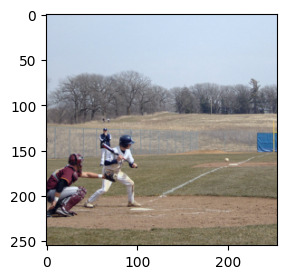

In [23]:
# Mari memvisualisasikan seluruh kumpulan gambar!
plt.figure(figsize = (3,3))
out = torchvision.utils.make_grid(test_image, 1, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))
print(test_captions[index])

In [24]:
# Tambahkan token Awal Kalimat ke perintah untuk memberi sinyal pada jaringan agar mulai membuat teks
sos_token = 101 * torch.ones(1, 1).long()

# Atur suhu untuk pengambilan sampel selama pembangkitan
temp = 0.5

In [25]:
log_tokens = [sos_token]
caption_model.eval()

with torch.no_grad():
    # Enkode gambar masukan
    with torch.amp.autocast("cuda"):
        # Forward pass
        image_embedding = caption_model.encoder(test_image.to(device))

    # Hasilkan token jawaban
    for i in range(50):
        input_tokens = torch.cat(log_tokens, 1)
        
        # Dekode token masukan menjadi token prediksi berikutnya
        data_pred = caption_model.decoder(input_tokens.to(device), image_embedding)
        
        # Sampel dari distribusi probabilitas yang diprediksi
        dist = Categorical(logits=data_pred[:, -1] / temp)
        next_tokens = dist.sample().reshape(1, 1)
        
        # Tambahkan token prediksi berikutnya ke urutan
        log_tokens.append(next_tokens.cpu())
        
        # Putuskan perulangan jika token End-Of-Caption diprediksi
        if next_tokens.item() == 102:
            break

In [26]:
# Ubah daftar indeks token menjadi tensor
pred_text = torch.cat(log_tokens, 1)

# Konversikan indeks token ke string yang sesuai menggunakan kosakata
pred_text_strings = tokenizer.decode(pred_text[0], skip_special_tokens=True)

# Bergabunglah dengan string token untuk membentuk teks prediksi
pred_text = "".join(pred_text_strings)

a group of people are on a field playing baseball.


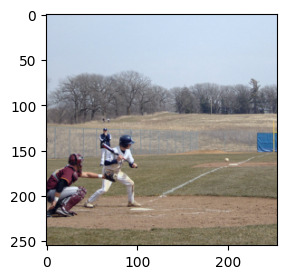

In [27]:
# Mari memvisualisasikan seluruh kumpulan gambar!
plt.figure(figsize = (3, 3))
out = torchvision.utils.make_grid(test_image, 1, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

# Cetak teks prediksi
print(pred_text)

In [28]:
import pandas as pd

# Tentukan panjang minimum dari kedua list
min_length = min(len(training_loss_logger), len(eval_loss_logger))

# Buat list epoch berdasarkan panjang minimum
epochs = list(range(1, min_length + 1))

# Buat DataFrame dengan slicing kedua list
df = pd.DataFrame({
    "Epoch": epochs,
    "Training Loss": training_loss_logger[:min_length],
    "Evaluation Loss": eval_loss_logger[:min_length]
})

print(df)

       Epoch  Training Loss  Evaluation Loss
0          1      10.609673         3.903516
1          2      10.183311         4.108263
2          3      10.005036         3.854953
3          4       9.845728         4.299105
4          5       9.652325         3.917135
...      ...            ...              ...
31645  31646       3.464972         2.447868
31646  31647       3.699421         2.782507
31647  31648       3.354446         2.311464
31648  31649       3.657432         2.593189
31649  31650       3.621812         2.426471

[31650 rows x 3 columns]
